In [1]:
pip install pandas numpy matplotlib kmodes scikit-learn prince gower

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [prince]
Note: you may need to restart the kernel to use updated packages.


In [22]:
import pandas as pd

df = pd.read_csv("/Users/apple/Downloads/Cleaned Student Data.csv")

#Quick glance
print(df.shape)
print(df.columns.tolist())
print(df.head().T)


(72, 17)
['1. Are you an International Student or a Local Student?', '2. What is your gender?', '3. Where do you mainly stay during the school term?', '4. Which mobile provider do you currently use?', '5. How do you usually connect to the internet in the following situations? [At home]', '5. How do you usually connect to the internet in the following situations? [On campus]', '5. How do you usually connect to the internet in the following situations? [While commuting / outside]', '6. Approximately how much data do you use each month?', '7. How much do you typically spend on your mobile plan per month? (SGD)', '8. What would be the top reason you might switch your current provider?', '9. What do you primarily use mobile data for?', '10. Please rate the following mobile plans based on your personal preference. (1 = lowest score, 5 = highest score) [Data: 500GB | Global Roaming: 8GB | APAC: 18GB | SG + IDD: 600 mins | Price: $12]', '10. Please rate the following mobile plans based on your

In [23]:
df = df.rename(columns={
    "1. Are you an International Student or a Local Student?": "student_type",
    "2. What is your gender?": "gender",
    "3. Where do you mainly stay during the school term?": "residence",
    "4. Which mobile provider do you currently use?": "mobile_provider",
    "5. How do you usually connect to the internet in the following situations? [At home]": "internet_home",
    "5. How do you usually connect to the internet in the following situations? [On campus]": "internet_campus",
    "5. How do you usually connect to the internet in the following situations? [While commuting / outside]": "internet_commuting",
    "6. Approximately how much data do you use each month?": "data_usage",
    "7. How much do you typically spend on your mobile plan per month? (SGD)": "monthly_spend",
    "8. What would be the top reason you might switch your current provider?": "switch_reason",
    "9. What do you primarily use mobile data for?": "usage_purpose",
    "10. Please rate the following mobile plans based on your personal preference. (1 = lowest score, 5 = highest score) [Data: 500GB | Global Roaming: 8GB | APAC: 18GB | SG + IDD: 600 mins | Price: $12]": "plan_1_rating",
    "10. Please rate the following mobile plans based on your personal preference. (1 = lowest score, 5 = highest score) [Data: 700GB | Global Roaming: 15GB | APAC: 80GB | SG + IDD: 800 mins | Price: $25]": "plan_2_rating",
    "10. Please rate the following mobile plans based on your personal preference. (1 = lowest score, 5 = highest score) [Data: 600GB | Global Roaming: 12GB | APAC: 50GB | SG + IDD: 800 mins | Price: $20]": "plan_3_rating",
    "10. Please rate the following mobile plans based on your personal preference. (1 = lowest score, 5 = highest score) [Data: 500GB | Global Roaming: 10GB | APAC: 30GB | SG + IDD: 800 mins | Price: $18]": "plan_4_rating",
    "10. Please rate the following mobile plans based on your personal preference. (1 = lowest score, 5 = highest score) [Data: 400GB | Global Roaming: 3GB | APAC: 12GB | SG + IDD: 500 mins | Price: $10]": "plan_5_rating",
    "11. Do you prefer prepaid or postpaid plan?": "plan_type",
})


In [121]:
print(df.columns.tolist())
df.dtypes

['student_type', 'gender', 'residence', 'mobile_provider', 'internet_home', 'internet_campus', 'internet_commuting', 'data_usage', 'monthly_spend', 'switch_reason', 'usage_purpose', 'plan_1_rating', 'plan_2_rating', 'plan_3_rating', 'plan_4_rating', 'plan_5_rating', 'plan_type', 'data_usage_clean', 'data_usage_bin', 'monthly_spend_clean', 'monthly_spend_bucket', 'monthly_spend_bin', 'conjoint_pc1', 'conjoint_pc2', 'cluster']


student_type             object
gender                   object
residence                object
mobile_provider          object
internet_home            object
internet_campus          object
internet_commuting       object
data_usage               object
monthly_spend            object
switch_reason            object
usage_purpose            object
plan_1_rating             int64
plan_2_rating             int64
plan_3_rating             int64
plan_4_rating             int64
plan_5_rating             int64
plan_type                object
data_usage_clean         object
data_usage_bin            int64
monthly_spend_clean      object
monthly_spend_bucket     object
monthly_spend_bin         int64
conjoint_pc1            float64
conjoint_pc2            float64
cluster                   int32
dtype: object

In [31]:
import re
import numpy as np

# ---- Data usage normalization ----
def clean_data_usage(v):
    #Convert values like '10-30 GB' → '10-30' so they map correctly.
    if not isinstance(v, str):
        return np.nan
    v = v.strip().lower()
    v = v.replace("–", "-")  # unify dashes
    v = re.sub(r"\s+", "", v)  # remove spaces
    v = v.replace("gb", "")  # remove the 'GB' unit
    return v  # should now look like '<10', '10-30', '31-60', '>60'

usage_map = {"<10": 1, "10-30": 2, "31-60": 3, ">60": 4}

df["data_usage_clean"] = df["data_usage"].apply(clean_data_usage)
df["data_usage_bin"] = df["data_usage_clean"].map(usage_map)

# ---- Monthly spend normalization ----
def clean_monthly_spend(v):
    #Convert values like '$10-$20' → '10-20' for consistent mapping.
    if not isinstance(v, str):
        return np.nan
    v = v.strip().lower()
    v = v.replace("$", "")
    v = v.replace("–", "-")
    v = re.sub(r"\s+", "", v)
    return v

spend_bucket_map = {
    "<10": "<$10",
    "10-20": "$10-$20",
    "21-30": "$21-$30",
    "31-40": "$31-$40",
}
spend_bin_map = {"<$10": 1, "$10-$20": 2, "$21-$30": 3, "$31-$40": 4, "Other": 5}

df["monthly_spend_clean"] = df["monthly_spend"].apply(clean_monthly_spend)
df["monthly_spend_bucket"] = df["monthly_spend_clean"].map(spend_bucket_map).fillna("Other")
df["monthly_spend_bin"] = df["monthly_spend_bucket"].map(spend_bin_map)

# ---- Verify result ----
print(df[["data_usage","data_usage_clean","data_usage_bin",
          "monthly_spend","monthly_spend_clean","monthly_spend_bucket","monthly_spend_bin"]].head(10))


  data_usage data_usage_clean  data_usage_bin monthly_spend  \
0   10-30 GB            10-30               2       $10-$20   
1   10-30 GB            10-30               2       $10-$20   
2   10-30 GB            10-30               2          <$10   
3   10-30 GB            10-30               2       $10-$20   
4   10-30 GB            10-30               2       $10-$20   
5   31-60 GB            31-60               3       $10-$20   
6     >60 GB              >60               4       $31-$40   
7   10-30 GB            10-30               2          <$10   
8   31-60 GB            31-60               3       $10-$20   
9   10-30 GB            10-30               2       $10-$20   

  monthly_spend_clean monthly_spend_bucket  monthly_spend_bin  
0               10-20              $10-$20                  2  
1               10-20              $10-$20                  2  
2                 <10                 <$10                  1  
3               10-20              $10-$20        

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np

plan_cols = ["plan_1_rating","plan_2_rating","plan_3_rating","plan_4_rating","plan_5_rating"]
Xq = df[plan_cols].copy()
Xq = Xq.apply(pd.to_numeric, errors="coerce").fillna(Xq.median(numeric_only=True))

Xq_scaled = StandardScaler().fit_transform(Xq.values)
pca = PCA(n_components=2, random_state=42)
pcs = pca.fit_transform(Xq_scaled)
df["conjoint_pc1"] = pcs[:, 0]
df["conjoint_pc2"] = pcs[:, 1]

# optional: see what PC1 and PC2 represent
loadings = pd.DataFrame(pca.components_.T, index=plan_cols, columns=["PC1","PC2"])
print(loadings)


                    PC1       PC2
plan_1_rating -0.291824  0.075979
plan_2_rating  0.586515 -0.423190
plan_3_rating  0.455653  0.456869
plan_4_rating -0.153766  0.719972
plan_5_rating -0.582731 -0.296729


In [35]:
print(df.head().T)

                                             0                         1  \
student_type             International Student     International Student   
gender                                  Female                    Female   
residence             Off-campus (near campus)  Off-campus (near campus)   
mobile_provider                          Simba                        M1   
internet_home                     Mostly Wi-Fi              Mostly Wi-Fi   
internet_campus                   Mostly Wi-Fi              Mostly Wi-Fi   
internet_commuting          Mostly Mobile Data        Mostly Mobile Data   
data_usage                            10-30 GB                  10-30 GB   
monthly_spend                          $10-$20                   $10-$20   
switch_reason                    Cheaper price     Faster network speeds   
usage_purpose          Video calls / messaging   Video calls / messaging   
plan_1_rating                                5                         2   
plan_2_ratin

In [37]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

categorical_cols = [
    "student_type","gender","residence","mobile_provider",
    "internet_home","internet_campus","internet_commuting",
    "switch_reason","usage_purpose","plan_type"
]
categorical_cols = [c for c in categorical_cols if c in df.columns]

numeric_cols = ["data_usage_bin","monthly_spend_bin","conjoint_pc1","conjoint_pc2"]

# numeric block
X_num = df[numeric_cols].copy()
X_num = X_num.fillna(X_num.median())
num_scaler = StandardScaler()
X_num_scaled = num_scaler.fit_transform(X_num.values)

# categorical block
if categorical_cols:
    X_cat_raw = df[categorical_cols].astype(str).fillna("missing")
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    X_cat = ohe.fit_transform(X_cat_raw)
else:
    X_cat = np.empty((len(df), 0))

import numpy as np
X = np.hstack([X_num_scaled, X_cat])


In [38]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd

def try_k(X, ks=(3,4,5,6,7)):
    rows = []
    for k in ks:
        km = KMeans(n_clusters=k, n_init=25, random_state=42)
        labels = km.fit_predict(X)
        sil = silhouette_score(X, labels) if len(set(labels)) > 1 else -1
        rows.append((k, sil))
    return pd.DataFrame(rows, columns=["k","silhouette"])

metrics = try_k(X)
print(metrics.sort_values("silhouette", ascending=False))
best_k = int(metrics.loc[metrics["silhouette"].idxmax(), "k"])
print("Chosen k:", best_k)


   k  silhouette
3  6    0.373087
4  7    0.372688
2  5    0.355014
1  4    0.347984
0  3    0.326878
Chosen k: 6


In [39]:
def sizes_for_k(X, k):
    from sklearn.cluster import KMeans
    km = KMeans(n_clusters=k, n_init=50, random_state=42)
    labels = km.fit_predict(X)
    sizes = pd.Series(labels).value_counts().sort_index()
    return sizes, labels

sizes6, labels6 = sizes_for_k(X, 6)
print(sizes6)  # make sure none are tiny (e.g., < 6)


0    10
1     9
2     5
3    37
4     9
5     2
Name: count, dtype: int64


In [40]:
tol = 0.01  # tolerance for "close enough"
best = metrics["silhouette"].max()
candidates = metrics[metrics["silhouette"] >= best - tol].sort_values(["k"])
print(candidates)
best_k_pars = int(candidates.iloc[0]["k"])
print("Parsimonious k:", best_k_pars)


   k  silhouette
3  6    0.373087
4  7    0.372688
Parsimonious k: 6


In [41]:
km = KMeans(n_clusters=best_k, n_init=50, random_state=42)
labels = km.fit_predict(X)
df["cluster"] = labels


In [42]:
def top_counts(s, topn=5):
    vc = s.value_counts(dropna=False)
    total = vc.sum()
    return " | ".join([f"{idx}: {cnt} ({cnt/total:.1%})" for idx, cnt in vc.head(topn).items()])

rows = []
for c, g in df.groupby("cluster"):
    row = {"cluster": int(c), "n": len(g)}
    for col in categorical_cols:
        row[f"{col}_top"] = top_counts(g[col])
    row["data_usage_bin_median"] = float(g["data_usage_bin"].median())
    row["monthly_spend_bin_median"] = float(g["monthly_spend_bin"].median())
    row["conjoint_pc1_mean"] = float(g["conjoint_pc1"].mean())
    row["conjoint_pc2_mean"] = float(g["conjoint_pc2"].mean())
    rows.append(row)

summary = pd.DataFrame(rows).sort_values("cluster").reset_index(drop=True)
print(summary)


   cluster   n                                   student_type_top  \
0        0  10                 International Student: 10 (100.0%)   
1        1   9                  International Student: 9 (100.0%)   
2        2   5                  International Student: 5 (100.0%)   
3        3  37  International Student: 36 (97.3%) | Local Stud...   
4        4   9  International Student: 8 (88.9%) | Local Stude...   
5        5   2                  International Student: 2 (100.0%)   

                            gender_top  \
0  Female: 6 (60.0%) | Male: 4 (40.0%)   
1  Female: 6 (66.7%) | Male: 3 (33.3%)   
2  Female: 4 (80.0%) | Male: 1 (20.0%)   
3  Female: 35 (94.6%) | Male: 2 (5.4%)   
4  Female: 7 (77.8%) | Male: 2 (22.2%)   
5                   Female: 2 (100.0%)   

                                       residence_top  \
0  Off-campus (near campus): 6 (60.0%) | Off-camp...   
1  Off-campus (near campus): 8 (88.9%) | Off-camp...   
2  Off-campus (near campus): 4 (80.0%) | Off-camp... 

In [43]:
def name_segment(r):
    parts = []
    if r.get("monthly_spend_bin_median", 3) >= 4:
        parts.append("Higher spenders")
    elif r.get("monthly_spend_bin_median", 3) <= 2:
        parts.append("Budget focused")
    if r.get("data_usage_bin_median", 2) >= 3:
        parts.append("Heavy data")
    else:
        parts.append("Light data")
    return " - ".join(parts)

summary["segment_name"] = summary.apply(name_segment, axis=1)
print(summary[["cluster","n","segment_name"]])


   cluster   n                 segment_name
0        0  10  Budget focused - Light data
1        1   9  Budget focused - Heavy data
2        2   5  Budget focused - Light data
3        3  37  Budget focused - Light data
4        4   9  Budget focused - Light data
5        5   2                   Heavy data


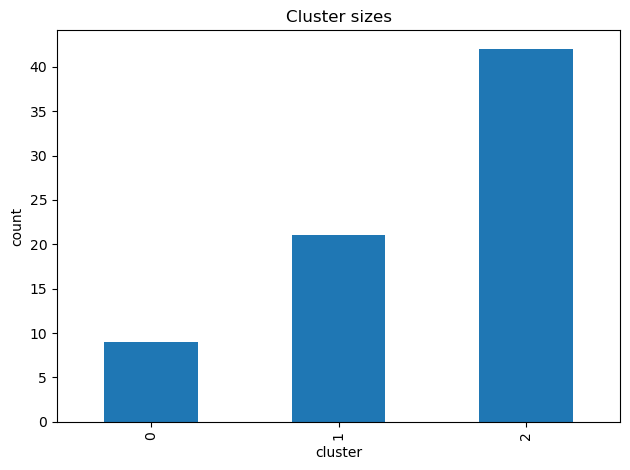

In [58]:
import matplotlib.pyplot as plt

def plot_sizes(labels):
    pd.Series(labels).value_counts().sort_index().plot(kind="bar")
    plt.title("Cluster sizes")
    plt.xlabel("cluster"); plt.ylabel("count"); plt.tight_layout(); plt.show()

# after choosing final k
km = KMeans(n_clusters=3, n_init=50, random_state=42)
labels = km.fit_predict(X)
plot_sizes(labels)


In [131]:
from sklearn.cluster import KMeans

k = 3
km = KMeans(n_clusters=k, n_init=50, random_state=42)
labels = km.fit_predict(X)
df["cluster"] = labels

# quick sizes
sizes = df["cluster"].value_counts().sort_index()
print("Cluster sizes:\n", sizes)


Cluster sizes:
 cluster
0     9
1    21
2    42
Name: count, dtype: int64


In [132]:
from sklearn.metrics import silhouette_score

sil = silhouette_score(X, labels)
print(f"Silhouette (k=3): {sil:.3f}")


Silhouette (k=3): 0.327


In [133]:
import pandas as pd

categorical_cols = [
    "student_type","gender","residence","mobile_provider",
    "internet_home","internet_campus","internet_commuting",
    "switch_reason","usage_purpose","plan_type"
]
categorical_cols = [c for c in categorical_cols if c in df.columns]
numeric_cols = ["data_usage_bin","monthly_spend_bin","conjoint_pc1","conjoint_pc2"]

def top_counts(s, topn=5):
    vc = s.value_counts(dropna=False)
    total = vc.sum()
    return " | ".join([f"{idx}: {cnt} ({cnt/total:.1%})" for idx, cnt in vc.head(topn).items()])

rows = []
for c, g in df.groupby("cluster"):
    row = {"cluster": int(c), "n": len(g)}
    for col in categorical_cols:
        row[f"{col}_top"] = top_counts(g[col])
    for col in numeric_cols:
        if col in g:
            row[f"{col}_median"] = float(g[col].median())
    rows.append(row)

summary = pd.DataFrame(rows).sort_values("cluster").reset_index(drop=True)
summary


,cluster,n,student_type_top,gender_top,residence_top,mobile_provider_top,internet_home_top,internet_campus_top,internet_commuting_top,switch_reason_top,usage_purpose_top,plan_type_top,data_usage_bin_median,monthly_spend_bin_median,conjoint_pc1_median,conjoint_pc2_median
0,0,9,International Student: 8 (88.9%) | Local Stude...,Female: 7 (77.8%) | Male: 2 (22.2%),Off-campus (near campus): 4 (44.4%) | Off-camp...,Simba: 3 (33.3%) | CMLink: 3 (33.3%) | Eight: ...,Mostly Wi-Fi: 9 (100.0%),Mostly Wi-Fi: 7 (77.8%) | Mostly Mobile Data: ...,Mostly Mobile Data: 8 (88.9%) | Mostly Wi-Fi: ...,Cheaper price: 7 (77.8%) | Faster network spee...,"Social media (Instagram, TikTok, etc.): 8 (88....",Postpaid: 6 (66.7%) | Prepaid: 3 (33.3%),2.0,1.0,-0.825292,-0.060349
1,1,21,International Student: 21 (100.0%),Female: 14 (66.7%) | Male: 7 (33.3%),Off-campus (near campus): 16 (76.2%) | Off-cam...,Singtel: 15 (71.4%) | Simba: 2 (9.5%) | M1: 1 ...,Mostly Wi-Fi: 16 (76.2%) | Mostly Mobile Data:...,Mostly Wi-Fi: 16 (76.2%) | Mostly Mobile Data:...,Mostly Mobile Data: 21 (100.0%),Cheaper price: 7 (33.3%) | Faster network spee...,"Social media (Instagram, TikTok, etc.): 9 (42....",Prepaid: 16 (76.2%) | Postpaid: 5 (23.8%),3.0,2.0,1.350812,0.387769
2,2,42,International Student: 41 (97.6%) | Local Stud...,Female: 39 (92.9%) | Male: 3 (7.1%),Off-campus (near campus): 38 (90.5%) | Off-cam...,Simba: 31 (73.8%) | Singtel: 8 (19.0%) | M1: 2...,Mostly Wi-Fi: 41 (97.6%) | Mostly Mobile Data:...,Mostly Wi-Fi: 40 (95.2%) | Mostly Mobile Data:...,Mostly Mobile Data: 42 (100.0%),Cheaper price: 33 (78.6%) | Student perks (e.g...,"Social media (Instagram, TikTok, etc.): 36 (85...",Prepaid: 41 (97.6%) | Postpaid: 1 (2.4%),2.0,2.0,-0.935754,-0.060349


In [134]:
def name_segment(r):
    parts = []
    ms = r.get("monthly_spend_bin_median", 3)
    du = r.get("data_usage_bin_median", 2)
    parts.append("Budget focused" if ms <= 2 else ("Higher spenders" if ms >= 4 else "Mid spend"))
    parts.append("Heavy data" if du >= 3 else "Light data")
    return " - ".join(parts)

summary["segment_name"] = summary.apply(name_segment, axis=1)
summary[["cluster","n","segment_name"]]


,cluster,n,segment_name
0,0,9,Budget focused - Light data
1,1,21,Budget focused - Heavy data
2,2,42,Budget focused - Light data


In [135]:
plan_cols = ["plan_1_rating","plan_2_rating","plan_3_rating","plan_4_rating","plan_5_rating"]
plan_pref = df.groupby("cluster")[plan_cols].mean().round(2)
plan_pref

plan_pref.rank(ascending=False, axis=1, method="dense").astype(int)


,plan_1_rating,plan_2_rating,plan_3_rating,plan_4_rating,plan_5_rating
cluster,,,,,
0,2,5,4,3,1
1,1,5,2,3,4
2,2,5,4,3,1


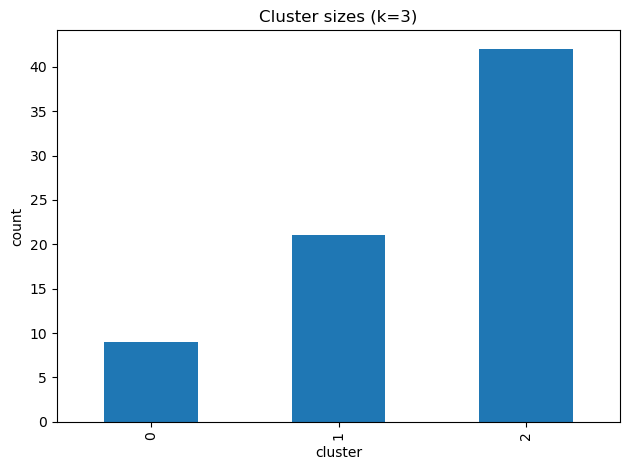

In [136]:
import matplotlib.pyplot as plt
df["cluster"].value_counts().sort_index().plot(kind="bar")
plt.title("Cluster sizes (k=3)")
plt.xlabel("cluster")
plt.ylabel("count")
plt.tight_layout()
plt.show()


In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA

# assumes df already has: cluster, data_usage_bin, monthly_spend_bin, conjoint_pc1, conjoint_pc2
plan_cols = ["plan_1_rating","plan_2_rating","plan_3_rating","plan_4_rating","plan_5_rating"]
categorical_cols = [
    "student_type","gender","residence","mobile_provider",
    "internet_home","internet_campus","internet_commuting",
    "switch_reason","usage_purpose","plan_type"
]
categorical_cols = [c for c in categorical_cols if c in df.columns]
numeric_cols = [c for c in ["data_usage_bin","monthly_spend_bin","conjoint_pc1","conjoint_pc2"] if c in df.columns]


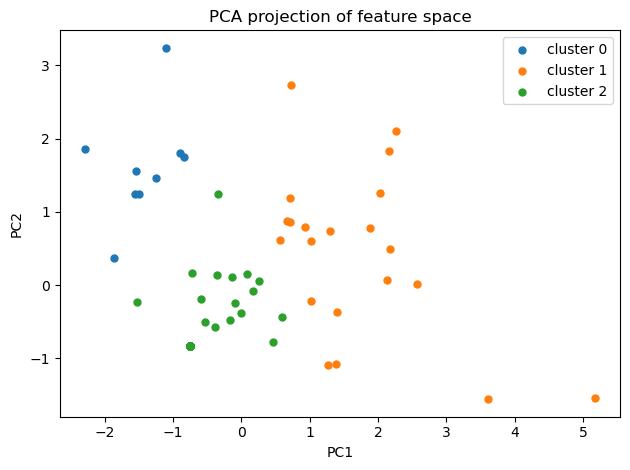

In [138]:
# rebuild X exactly like you used for KMeans
X_num = df[numeric_cols].copy().fillna(df[numeric_cols].median())
num_scaler = StandardScaler().fit(X_num.values)
X_num_scaled = num_scaler.transform(X_num.values)

if categorical_cols:
    X_cat_raw = df[categorical_cols].astype(str).fillna("missing")
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False).fit(X_cat_raw)
    X_cat = ohe.transform(X_cat_raw)
else:
    X_cat = np.empty((len(df), 0))

X = np.hstack([X_num_scaled, X_cat])

# PCA to 2D for plotting only
p = PCA(n_components=2, random_state=42).fit(X)
XY = p.transform(X)

plt.figure()
for c in sorted(df["cluster"].unique()):
    idx = df["cluster"] == c
    plt.scatter(XY[idx, 0], XY[idx, 1], label=f"cluster {c}", s=25)
plt.title("PCA projection of feature space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.tight_layout()
plt.show()


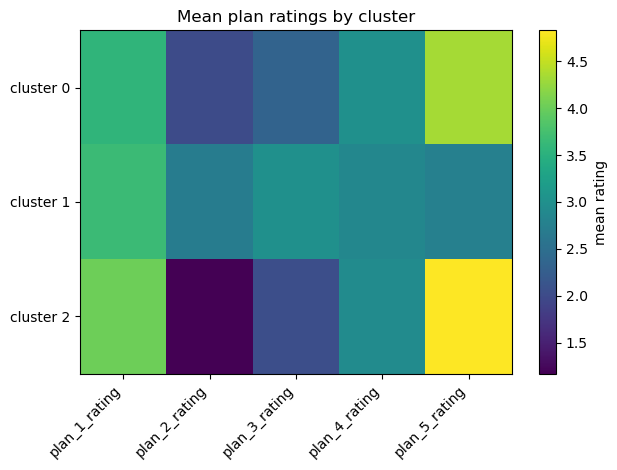

In [139]:
means = df.groupby("cluster")[plan_cols].mean().round(2)

plt.figure()
plt.imshow(means.values, aspect="auto")
plt.xticks(ticks=range(len(plan_cols)), labels=plan_cols, rotation=45, ha="right")
plt.yticks(ticks=range(len(means.index)), labels=[f"cluster {c}" for c in means.index])
plt.colorbar(label="mean rating")
plt.title("Mean plan ratings by cluster")
plt.tight_layout()
plt.show()


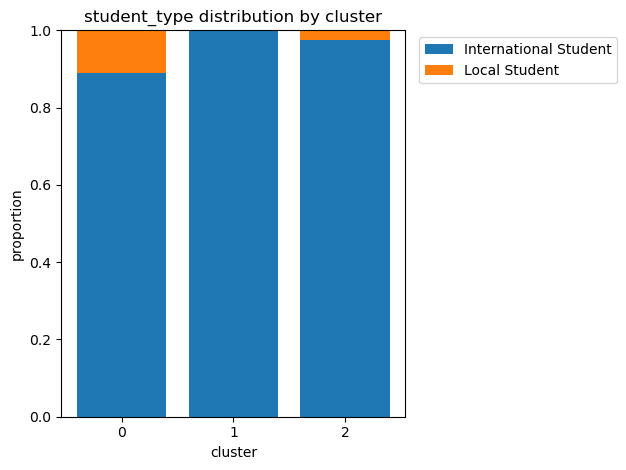

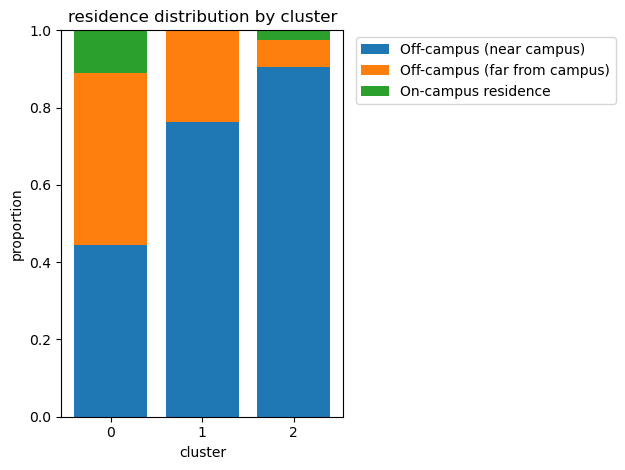

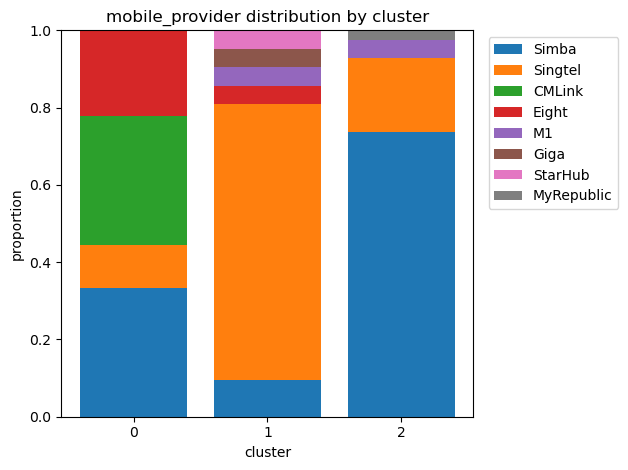

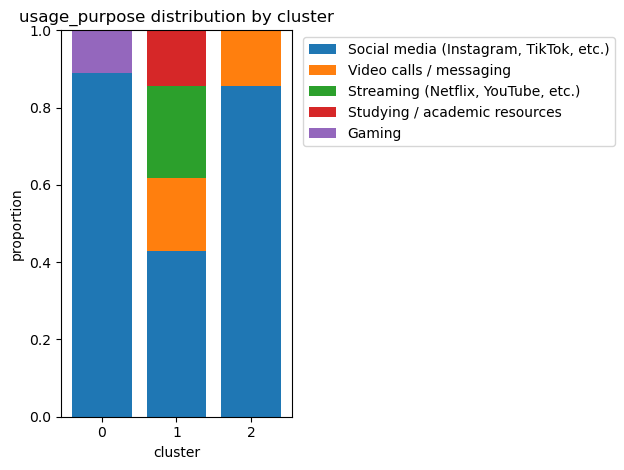

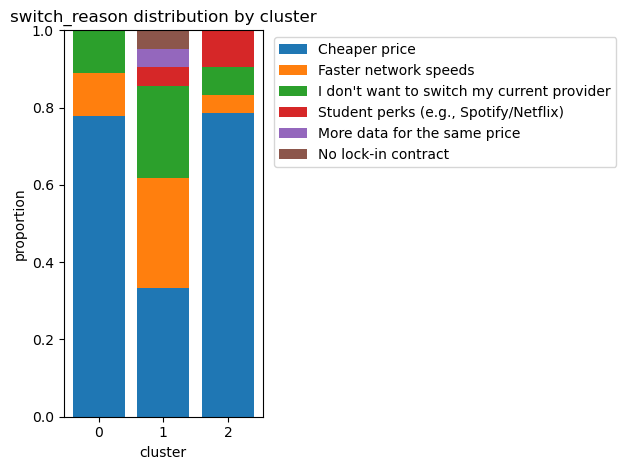

In [140]:
def stacked_prop_by_cluster(df, col):
    tab = pd.crosstab(df["cluster"], df[col], normalize="index")
    order = tab.sum().sort_values(ascending=False).index  # most common categories first
    tab = tab[order]

    plt.figure()
    bottom = np.zeros(len(tab))
    for cat in tab.columns:
        plt.bar(tab.index.astype(str), tab[cat].values, bottom=bottom, label=cat)
        bottom += tab[cat].values
    plt.title(f"{col} distribution by cluster")
    plt.xlabel("cluster")
    plt.ylabel("proportion")
    plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

# pick a few important categorical variables
for col in ["student_type","residence","mobile_provider","usage_purpose","switch_reason"]:
    if col in df.columns:
        stacked_prop_by_cluster(df, col)


In [114]:
df.groupby("cluster")[["conjoint_pc1","conjoint_pc2","monthly_spend_bin","data_usage_bin"]].mean()


,conjoint_pc1,conjoint_pc2,monthly_spend_bin,data_usage_bin
cluster,,,,
0,0.112702,-0.083865,1.000000,1.777778
1,1.465846,0.270690,2.190476,2.904762
2,-0.757073,-0.117374,2.000000,1.976190


In [120]:
df.to_csv("/Users/apple/Downloads/labeled_responses_k3.csv", index=False)
summary.to_csv("/Users/apple/Downloads/cluster_summary_k3.csv", index=False)
plan_pref.to_csv("/Users/apple/Downloads/cluster_plan_means_k3.csv")
